In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import lag_plot
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm

%matplotlib inline

In [2]:
df = pd.read_csv('Online Retail.csv')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], )

In [6]:
df['InvoiceDate'][0]

Timestamp('2010-12-01 08:26:00')

In [7]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [8]:
df.sort_values('InvoiceDate',inplace=True)

# EDA

## range of date

In [9]:
date_col = df['InvoiceDate'] 
print(f'The date range is from {date_col.min()} to {date_col.max()} with an interval of {date_col.max() - date_col.min()}')

The date range is from 2010-12-01 08:26:00 to 2011-12-09 12:50:00 with an interval of 373 days 04:24:00


## counts of time differences between two consecutive records -- time frequency
* depending the task we may need to may attention to the sparsity of the records, especially for individual item for individual country

In [10]:
timedelta_days = date_col.diff().apply(lambda x: x.floor('h')/pd.Timedelta('1 hour'))

<AxesSubplot:>

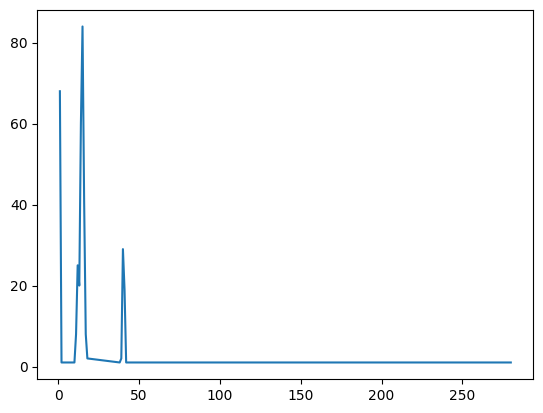

In [11]:
x = timedelta_days.value_counts()
x.sort_index()[1:].plot()

## data counts per stock

* There are maybe many items doesn't have enough data to do prediction

<AxesSubplot:ylabel='Frequency'>

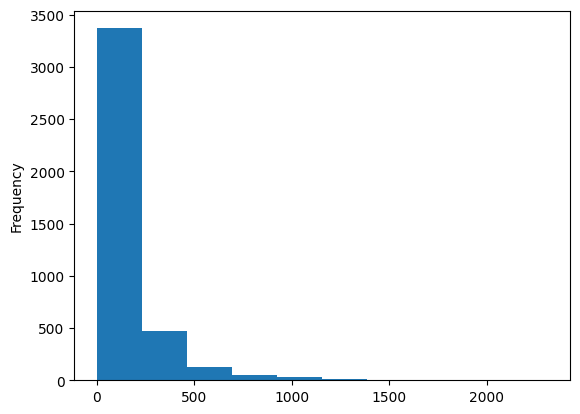

In [12]:
df['StockCode'].value_counts().plot(kind='hist')

* ### Counts by country

<AxesSubplot:xlabel='Country', ylabel='Quantity'>

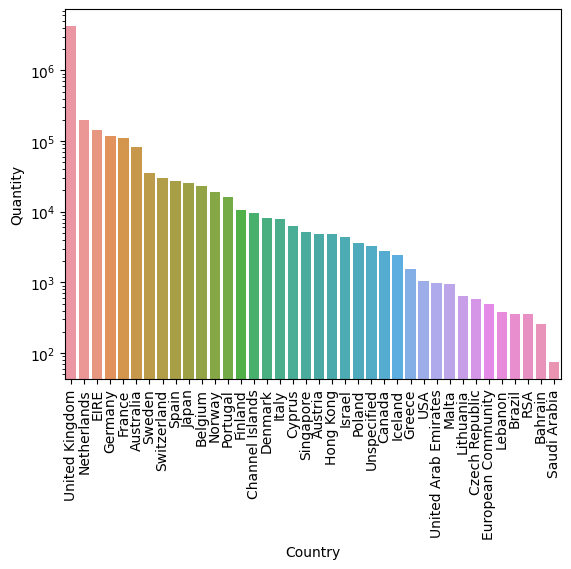

In [13]:
gb_country = df.groupby('Country').sum()['Quantity']

fig, ax = plt.subplots()

# Set the log scale for y-axis
ax.set(yscale="log")
for label in ax.get_xticklabels():
    label.set_rotation(90)

sns.barplot(x='Country', y='Quantity', data=gb_country.reset_index(), order=gb_country.sort_values(ascending=False).index)

## focus only on the top three items which have the greatest sells across all countries.

* Since the objective is to help the company prepare for the worst case, each company should be well-prepared for their price-weighted top selling items in each country (assuming higher price, larger margin for profit). 
* Choose the top three items that generates highest income across all the countries.

In [14]:
# define a new Income column as the product of Quantity and UnitPrice
df['Income'] = df['Quantity']*df['UnitPrice']

In [15]:
top_three = df[['Quantity','StockCode', 'Income','Country','InvoiceDate']].query(
                "'2011-12-03' >= InvoiceDate >= '2011-11-27' ").groupby(
                ['StockCode','Country']).sum().sort_values(
                 'Income', ascending=False).index[:3]
top_three = set(top_three)
#for item in top_three:
print(f'The top three items across all countries are {top_three}')

The top three items across all countries are {('DOT', 'United Kingdom'), ('23084', 'United Kingdom'), ('22086', 'United Kingdom')}


### extract the top three items as model_data

In [16]:
model_data = df[df[['StockCode','Country']].apply(lambda x: (x['StockCode'],x['Country']) in top_three,axis=1)]
model_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Income
46,536371,22086,PAPER CHAIN KIT 50'S CHRISTMAS,80,2010-12-01 09:00:00,2.55,13748.0,United Kingdom,204.00
122,536381,22086,PAPER CHAIN KIT 50'S CHRISTMAS,4,2010-12-01 09:41:00,2.95,15311.0,United Kingdom,11.80
382,536402,22086,PAPER CHAIN KIT 50'S CHRISTMAS,40,2010-12-01 11:22:00,2.55,15513.0,United Kingdom,102.00
599,536412,22086,PAPER CHAIN KIT 50'S CHRISTMAS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom,2.95
655,536415,22086,PAPER CHAIN KIT 50'S CHRISTMAS,6,2010-12-01 11:57:00,2.95,12838.0,United Kingdom,17.70


## count the number of orders with the same quantity
* to see the repeated orders with the same quantity.
* DOT is a special item having only order size of one except a large purchase of 708.

In [17]:
for item in top_three:
    print(item)
    print(model_data.query(f'StockCode =="{item[0]}"')['Quantity'].value_counts())

('DOT', 'United Kingdom')
 1       708
-1         1
 1000      1
Name: Quantity, dtype: int64
('23084', 'United Kingdom')
 6     154
 1     150
 24     84
 12     82
 2      80
      ... 
 52      1
 49      1
 46      1
 36      1
-45      1
Name: Quantity, Length: 76, dtype: int64
('22086', 'United Kingdom')
6     249
1     200
12    137
2     107
40     87
     ... 
51      1
53      1
55      1
58      1
38      1
Name: Quantity, Length: 72, dtype: int64


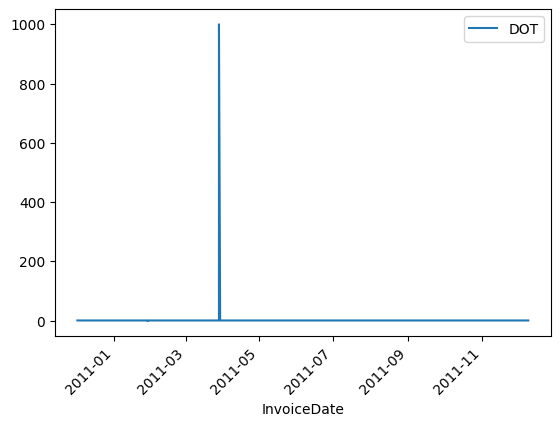

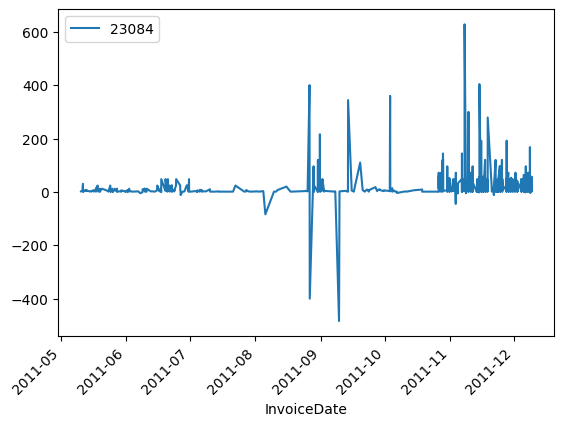

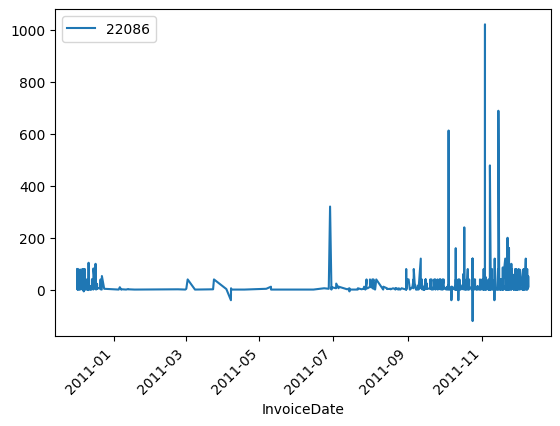

In [18]:
for item in top_three:
    model_data.query(f'StockCode =="{item[0]}"').plot(x='InvoiceDate',y='Quantity',label=item[0])
    plt.xticks(rotation=45)

### Does the same item from the same country has duplication for a given time?
* Yes, we will merge those into one entry corresponding to the same datetime point.

In [19]:
duplicate_idx = model_data['InvoiceDate'].value_counts()[model_data['InvoiceDate'].value_counts()>1]
for idx in duplicate_idx.index[:2]:
    print(model_data.drop(['Description','CustomerID','InvoiceNo','Income'],axis=1).query(f'InvoiceDate == "{idx}"'))

       StockCode  Quantity         InvoiceDate  UnitPrice         Country
439819     23084         1 2011-11-04 12:45:00       2.08  United Kingdom
439836     23084         1 2011-11-04 12:45:00       2.08  United Kingdom
439805     23084         1 2011-11-04 12:45:00       2.08  United Kingdom
439841     23084         1 2011-11-04 12:45:00       2.08  United Kingdom
439730     23084         4 2011-11-04 12:45:00       2.08  United Kingdom
439746     23084         1 2011-11-04 12:45:00       2.08  United Kingdom
       StockCode  Quantity         InvoiceDate  UnitPrice         Country
273063     23084         1 2011-07-21 09:30:00       4.13  United Kingdom
273113       DOT         1 2011-07-21 09:30:00     178.71  United Kingdom
273014     22086         1 2011-07-21 09:30:00       6.63  United Kingdom
273029     23084         1 2011-07-21 09:30:00       4.13  United Kingdom
273041       DOT         1 2011-07-21 09:30:00      79.83  United Kingdom
273036       DOT         1 2011-07-21 

**Merge the same-day sales together**

In [20]:
model_data['InvoiceDate_day'] = model_data['InvoiceDate'].apply(lambda x:x.floor('d'))

<ipython-input-20-f0ffe264fbff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['InvoiceDate_day'] = model_data['InvoiceDate'].apply(lambda x:x.floor('d'))


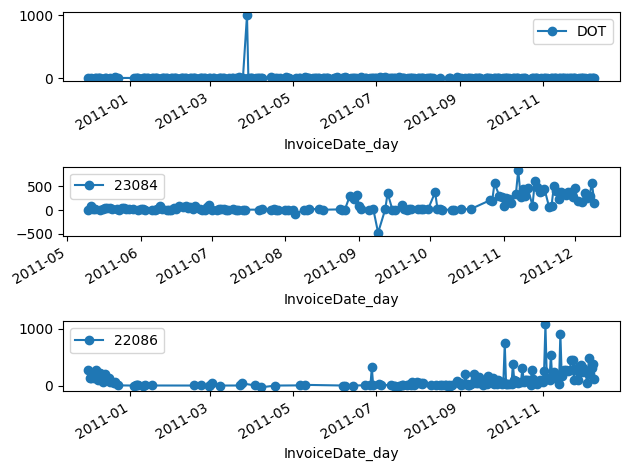

In [36]:
data = model_data.groupby(['StockCode','InvoiceDate_day']).sum()['Quantity'].sort_index()
for i,item in enumerate(top_three):
    plt.subplot(3,1,i+1)
    data.xs(item[0]).plot(style="-o",label=item[0])
    plt.legend()
plt.tight_layout()

In [37]:
train, test = pm.model_selection.train_test_split(data.xs('23084')[data.xs('23084').index>"2011-11-1"])

In [38]:
print(len(train),len(test))

24 9


<AxesSubplot:xlabel='InvoiceDate_day'>

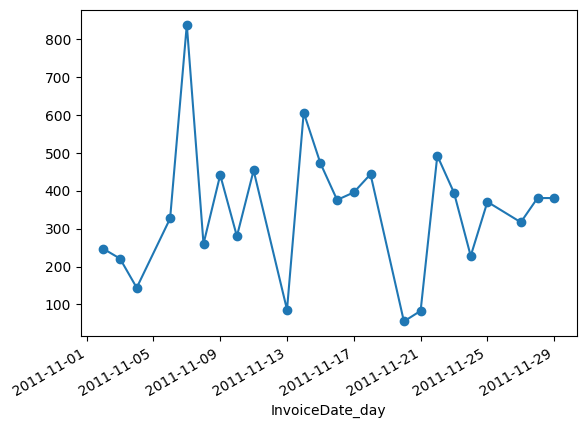

In [39]:
train.plot(style='o-')

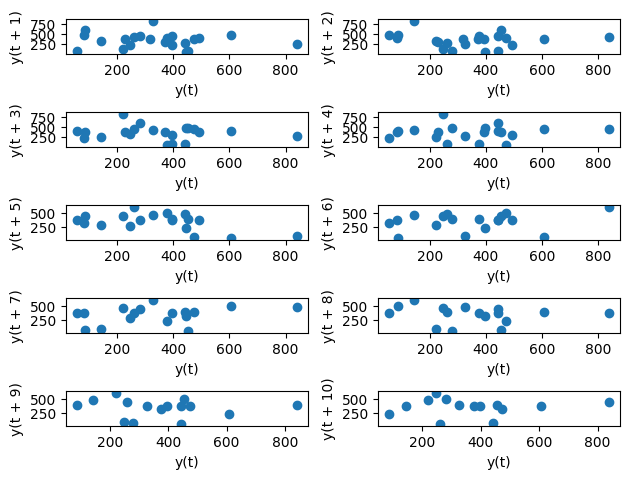

In [40]:
for i in range(1,11):
    plt.subplot(5,2,i)
    lag_plot(train,lag=i)
plt.tight_layout()

* showing data with little autocorrelation and serval outliers

/usr/local/lib/python3.9/site-packages/pmdarima/utils/visualization.py:219: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  res = tsaplots.plot_acf(


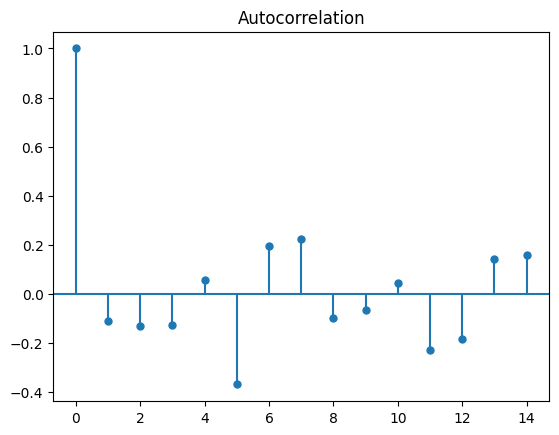

In [41]:
pm.plot_acf(train)

In [42]:
arima = pm.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=10)
arima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=330.863, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=318.944, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=320.670, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=320.935, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=355.971, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=322.719, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.189 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   24
Model:                        SARIMAX   Log Likelihood                -157.472
Date:                Fri, 05 Mar 2021   AIC                            318.944
Time:                        11:30:43   BIC                            321.301
Sample:                             0   HQIC                           319.570
                                 - 24                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    345.8333     37.205      9.295      0.000     272.912     418.755
sigma2      2.928e+04   7276.233      4.025      0.000     1.5e+04    4.35e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                 2.58
Prob(Q):                              0.57   Prob(JB):                         0.28
Heteroskedasticity (H):               0.34   Skew:                             0.60
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
from fbprophet import Prophet

In [44]:
data = data.reset_index()

In [45]:
data = data[['InvoiceDate_day','Quantity']].query('InvoiceDate_day <= "2011-12-03" ')

In [46]:
data.columns = ['ds','y']

train,test = data.iloc[:-7],data.iloc[-7:]

In [47]:
m = Prophet()
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [48]:
future = m.make_future_dataframe(periods=7)

In [49]:
forecast = m.predict(future)

(15298.0, 15313.0)

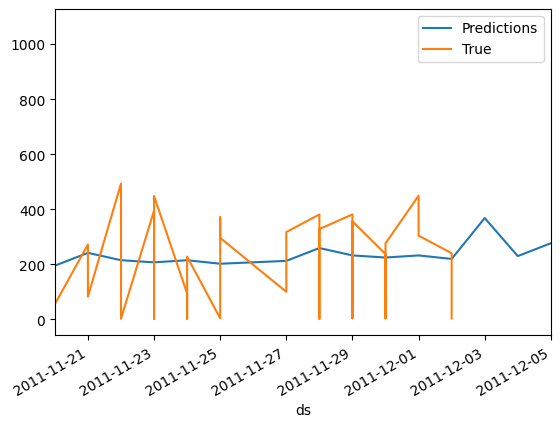

In [50]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions')
data = data[data['y']>1]
data.plot(x='ds',y='y',ax=ax,label='True')
ax.set_xlim("2011-11-20","2011-12-05")

In [51]:
from statsmodels.tools.eval_measures import rmse

In [52]:
predictions = forecast.iloc[-7:]['yhat']

In [53]:
rmse(predictions,test['y'])

265.59400623730113

In [132]:
forecast.iloc[-7:][['ds','yhat']].to_csv('Erpan_result.csv')